# Exploratory data analysis of the Maternal Health Risk Data Set

Team: 14

Team members: Lennon Au-Yeung, Chenyang Wang, Shirley Zhang

In [1]:
#import the required packages
import pandas as pd
from sklearn.model_selection import train_test_split
import altair as alt
alt.renderers.enable('mimetype')
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

# Summary of the data set

The data set used in this project consists of health information collected from the rural areas of Bangladesh created by Dr. Marzia Ahmed at the Daffodil International University. It was sourced from the UCI Machine Learning Repository and can be found [here](https://archive.ics.uci.edu/ml/datasets/Maternal+Health+Risk+Data+Set), specifically [this file](https://archive.ics.uci.edu/ml/machine-learning-databases/00639/Maternal%20Health%20Risk%20Data%20Set.csv). Each row in the data set consists of responsible and significant risk factors for maternal mortality (e.g., blood glucose levels, blood sugar and body temperature) and maternity risk level (high, mid, or low). Information was extracted through an IoT (Internet of Things) based risk monitoring system. There are 1014 observations in the data set, and 6 features. There are 0 observations with missing values in the data set.

In [2]:
#loading the data set
maternal_risk_df = pd.read_csv('../data/raw/maternal_risk.csv')

In [3]:
summary_df = pd.DataFrame(maternal_risk_df['RiskLevel'].value_counts()).rename(columns={'RiskLevel':''}).T
summary_df

,low risk,mid risk,high risk
,406,336,272


# Split data set into training and test splits

Before proceeding further, we will split the data such that 80% of observations are in the training and 20% of observations are in the test set.

In [4]:
#train_test_split
train_df, test_df = train_test_split(maternal_risk_df, test_size=0.20, random_state=123)

We also need to check that there are no null values in the data set.

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 811 entries, 375 to 510
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          811 non-null    int64  
 1   SystolicBP   811 non-null    int64  
 2   DiastolicBP  811 non-null    int64  
 3   BS           811 non-null    float64
 4   BodyTemp     811 non-null    float64
 5   HeartRate    811 non-null    int64  
 6   RiskLevel    811 non-null    object 
dtypes: float64(2), int64(4), object(1)
memory usage: 50.7+ KB


Table 1. Number of non-null values for each column.

In [6]:
train_df.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000
mean,29.574599,112.933416,76.262639,8.659211,98.680641,74.373613
std,13.287246,18.334896,13.764557,3.223935,1.379661,7.908723
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,95.000000,65.000000,6.900000,98.000000,70.000000
50%,25.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,37.500000,120.000000,90.000000,7.950000,98.000000,80.000000
max,66.000000,160.000000,100.000000,19.000000,103.000000,90.000000


Table 2. Statistics of each numeric columns.

Now we will explore the distribution of the classes (low risk, mid risk, high risk):

In [7]:
train_class_counts = pd.DataFrame(train_df['RiskLevel'].value_counts()).rename(columns={'RiskLevel':'train'})
test_class_counts = pd.DataFrame(test_df['RiskLevel'].value_counts()).rename(columns={'RiskLevel':'test'})

train_test_class_counts = pd.concat([train_class_counts, test_class_counts], axis=1)
train_test_class_counts

,train,test
low risk,325,81
mid risk,274,62
high risk,212,60


Table 3. Counts of observation for each class in both test and train.

<AxesSubplot:>

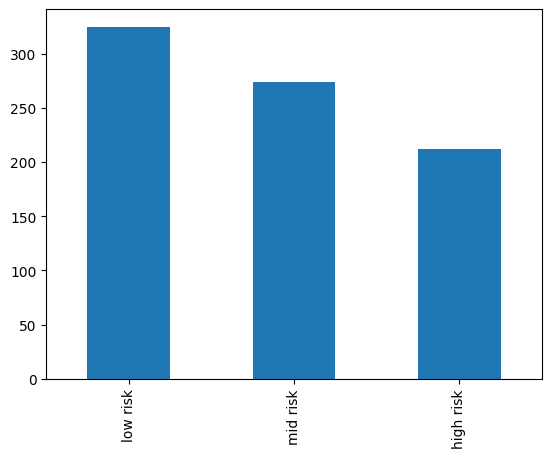

In [8]:
train_df['RiskLevel'].value_counts().plot(kind='bar')

Figure 1. Counts of observation for each class in train data set.

From the figure, we can see that there is a minor class imbalance, but it is not so great that immediate action needs to be taken. During hyperparameter optimization for improving model performance, we can further evaluate whether a balanced class weight will improve model performance or not.

# Exploratory analysis on the training data set

In [9]:
X_columns = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']

In [10]:
def display(i):
    graph = alt.Chart(train_df).transform_density(
    i,groupby=['RiskLevel'],
    as_=[ i, 'density']).mark_area(fill = None, strokeWidth=2).encode(
    x = (i),
    y='density:Q',stroke='RiskLevel').properties(width=200,height=200)
    return graph + graph.mark_area(opacity = 0.3).encode(color = alt.Color('RiskLevel',legend=None))

In [11]:
Age = display('Age')
SystolicBP = display('SystolicBP')
DiastolicBP = display('DiastolicBP')
BS = display('BS')
BodyTemp = display('BodyTemp')
HeartRate = display('HeartRate')

To see whether the predictors might be useful to predict the risk level, we plotted the distributions of each predictor from the training data and coloured the distribution by class (high risk: blue, mid risk: red and low risk: orange). 

In [12]:
((Age | SystolicBP | DiastolicBP) & (BS | BodyTemp | HeartRate)).properties(title='Distribution of predictors for each Risk Level')

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


Figure 2.  Distribution of training set predictors for high risk, mid risk and low risk

From the figure above, we can see that in SystolicBP and DiastolicBP, observations with high value in both of the categories are mostly associated with high maternity risk level. We can see that low blood glucose level is more associated with mid and low maternity risk level, while the density of high risk level in blood glucose level is the same throughout. For other predictors, we can see that the distribution is similar across all three risk levels.

To explore whether there is any interesting relationship between the predictors, we have plotted a correlation matrix and pairwise scatter plots for all the predictors.

In [13]:
train_df.corr('spearman').style.background_gradient()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
Age,1.000000,0.473240,0.430211,0.318194,-0.317851,0.072938
SystolicBP,0.473240,1.000000,0.752019,0.249512,-0.288564,-0.021214
DiastolicBP,0.430211,0.752019,1.000000,0.314118,-0.278765,-0.052615
BS,0.318194,0.249512,0.314118,1.000000,-0.015323,0.124527
BodyTemp,-0.317851,-0.288564,-0.278765,-0.015323,1.000000,0.088351
HeartRate,0.072938,-0.021214,-0.052615,0.124527,0.088351,1.000000


Table 4. Correlation matrix of all predictors

In [14]:
alt.Chart(train_df).mark_point(opacity=0.3, size=10).encode(
     alt.X(alt.repeat('row'), type='quantitative'),
     alt.Y(alt.repeat('column'), type='quantitative')
).properties(
    width=100,
    height=100
).repeat(
    column=['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate'],
    row=['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
)

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


Figure 3. Pairwise relationship between predictors.

From the above table and figure, we can see that the features SystolicBP and DiastolicBP have high correlation compared to other pairs of predictors, followed by the correlation between the two blood pressure levels and age. For other pairs of predictors, there are no significant correlations found.

# References

Dua, Dheeru, and Casey Graff. 2017. “UCI Machine Learning Repository.” University of California, Irvine, School of Information; Computer Sciences. http://archive.ics.uci.edu/ml.